# Whole Slide Image sampler module:

****
## Testing with:
```python
tensorflow==2.0.0rc0
```

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import os
import numpy as np

import openslide
from skimage.filters import threshold_otsu

import PIL

WORKING_THUMB_MAX_SIZE = [2048, 2048]
WORKING_THUMB_MIN_SIZE = [1024, 1024]


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def image_example(image_string, label):
    """ image_metadat_dict = image_example(image_string, label)
    Create a dictionary of jpg image features
    """
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {'height': _int64_feature(image_shape[0]),
               'width': _int64_feature(image_shape[1]),
               'depth': _int64_feature(image_shape[2]),
               'label': _int64_feature(label),
               'image_raw': _bytes_feature(image_string) }

    return tf.train.Example(features=tf.train.Features(feature=feature))


def raw_jpg_to_tfrecord(image_labels_dict, file_name='slide_images.tfrecords'):
    """ raw_jpg_to_tfrecord(image_labels_dict, file_name)
    write a jpg image to to a tfrecord
    """
    with tf.io.TFRecordWriter(file_name) as writer:
        for filename, label in image_labels_dict.items():
            image_string = open(filename, 'rb').read()
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())


def get_adjcent_segmented_length_fence_array(segment_length, length):
    """ fences = get_adjcent_segmented_length_fence_array(segment_length, length)
    """
    fences = {}
    n_fenced = length // segment_length
    n_remain = 1 + length % segment_length
    paddit = n_remain // 2
    if n_remain == segment_length:
        paddit = 0
        n_remain = 0
        n_fenced = n_fenced + 1
    
    fence_array = np.zeros((n_fenced, 2)).astype(int)
    for k in range(n_fenced):
        if k == 0:
            fence_array[k, 0] = paddit
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        elif fence_array[k-1, 1] + segment_length <= length:
            fence_array[k, 0] = fence_array[k-1, 1] + 1
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        
    fences['fence_array'] = fence_array
    fences['n_fenced'] = n_fenced
    fences['n_remain'] = n_remain
    fences['padding'] = paddit

    return fences


        
def get_patch_name_from_row_col(row, col, base_name='patch', file_ext='.jpg'):
    """ patch_name = get_patch_name_from_row_col(row, col, base_name='patch', 
                                                file_ext='.jpg') 
    """
    if file_ext[0] != '.':
        file_ext = '.' + file_ext
    patch_name = base_name + '_row_%i_%i'%(row[0], row[1])
    patch_name += '_col_%i_%i%s'%(col[0], col[1], file_ext)
    
    return patch_name


def get_row_col_from_patch_name(fname):
    """ row_col_dict = get_row_col_from_filename(fname) 
    """
    row_label = 'row'
    col_label = 'col'
    r = []
    c = []
    base_name, file_ext = os.path.splitext(os.path.split(fname)[1])
    parts_list = base_name.split('_')
    
    for i in range(len(parts_list)):
        if parts_list[i] == row_label:
            r.append(parts_list[i+1])
            r.append(parts_list[i+2])
        elif parts_list[i] == col_label:
            c.append(parts_list[i+1])
            c.append(parts_list[i+2])
    row = np.array(r).astype(np.int)
    col = np.array(c).astype(np.int)
    return {'base_name': parts_list[0], 'file_ext': file_ext, 'row': row, 'col': col }


def get_mask_w_scale_grid(os_obj, patch_height, patch_width):
    """ mask_dict = get_mask_w_scale_grid(svs_file_name, patch_height, patch_width)
    
    """
    close_os_obj = False
    if isinstance(os_obj, str) and os.path.isfile(os_obj):
        os_obj = openslide.OpenSlide(svs_file_name)
        close_os_obj = True
    
    #                               get the indexing arrays for the full size grid
    pixels_height = os_obj.dimensions[0]
    pixels_width = os_obj.dimensions[1]

    full_scale_rows_dict = get_adjcent_segmented_length_fence_array(segment_length=patch_height, 
                                                                    length=pixels_height)
    full_scale_cols_dict = get_adjcent_segmented_length_fence_array(segment_length=patch_width, 
                                                                    length=pixels_width)
    full_scale_rows_arrays = full_scale_rows_dict['fence_array']
    full_scale_cols_arrays = full_scale_cols_dict['fence_array']

    
    #                               determine thumbnail size & get the mask
    pixels_height_ds = os_obj.level_dimensions[-1][0]
    pixels_width_ds = os_obj.level_dimensions[-1][1]
    scale_determinant = max(pixels_height_ds, pixels_width_ds)
    
    thumbnail_divisor = 1
    don_t_b_dum = 10
    count = 0
    
    while scale_determinant // thumbnail_divisor > WORKING_THUMB_MAX_SIZE[0] and count < don_t_b_dum:
        count += 0
        thumbnail_divisor *= 2
    
    thumb_height = pixels_height_ds // thumbnail_divisor
    thumb_width = pixels_width_ds // thumbnail_divisor
    
    #                               get the indexing arrays for the thumbnail sized grid
    rows_divisor = pixels_height / thumb_height
    thumb_scale_rows_arrays = (full_scale_rows_arrays // rows_divisor).astype(int)
    cols_divisor = pixels_width / thumb_width
    thumb_scale_cols_arrays = (full_scale_cols_arrays // cols_divisor).astype(int)

    #                               git the mask image
    one_thumb = os_obj.get_thumbnail((thumb_height, thumb_width))
    grey_thumbnail = np.array(one_thumb.convert('L'))
    thresh = threshold_otsu(grey_thumbnail)
    mask = np.array(grey_thumbnail) < thresh
    mask_im = PIL.Image.fromarray(np.uint8(mask) * 255)

    if close_os_obj == True:
        os_obj.close()
        
    mask_dict = {'thumb_mask': mask_im, 
                 'full_scale_rows_dict': full_scale_rows_dict, 
                 'full_scale_cols_dict': full_scale_cols_dict, 
                 'full_scale_rows_arrays': full_scale_rows_arrays, 
                 'full_scale_cols_arrays': full_scale_cols_arrays,
                 'thumb_scale_rows_arrays': thumb_scale_rows_arrays, 
                 'thumb_scale_cols_arrays': thumb_scale_cols_arrays}
    
    return mask_dict


In [25]:
"""
svs_file_name
output_dir
patch_height
patch_width

write the files
"""
import time
def svs_file_to_patches_tfrecord(svs_file_name, output_dir, patch_size, patch_keep_threshold):
    """ 
    mask_dict = svs_file_to_patches_tfrecord(svs_file_name, output_dir, patch_height, patch_width=None)
    """
    walk_start_time = time.time()
    _, file_name_base = os.path.split(svs_file_name)
    file_name_base, _ = os.path.splitext(file_name_base)
    file_ext = '.jpg'
    print('file_name_base', file_name_base, '\nfile extension', file_ext)

    
    print('\nopening:\n', svs_file_name, '\nwrite to:\n', output_dir)
    
    patch_height = patch_size[0]
    patch_width = patch_size[1]
    print('patch_height: %i, patch_width:%i'%(patch_height, patch_width))
    
    os_obj = openslide.OpenSlide(svs_file_name)
    mask_dict = get_mask_w_scale_grid(os_obj, patch_height, patch_width)
    mask_im = mask_dict['thumb_mask']
    
    full_scale_rows_arrays = mask_dict['full_scale_rows_arrays']
    full_scale_cols_arrays = mask_dict['full_scale_cols_arrays']
    print('image height %i, width %i'%(os_obj.dimensions[0],os_obj.dimensions[1]))
    print('full_scale_rows_arrays.shape', full_scale_rows_arrays.shape)
    print('full_scale_cols_arrays.shape', full_scale_cols_arrays.shape)
    
    thumb_scale_rows_arrays = mask_dict['thumb_scale_rows_arrays']
    thumb_scale_cols_arrays = mask_dict['thumb_scale_cols_arrays']
    
    for row in range(full_scale_rows_arrays.shape[0]):
        if row % 10 == 0:
            print('row %3i: %03f'%(row, time.time() - walk_start_time))
        for col in range(full_scale_cols_arrays.shape[0]):
            r = thumb_scale_rows_arrays[row]
            c = thumb_scale_cols_arrays[col]
            area = (c[0], r[0], c[1], r[1])
            thumb_segment = mask_im.crop(area)
            thumb_arr = np.array(thumb_segment)
            mask_value = np.float(np.sum(thumb_arr==0)) / np.float(np.prod(thumb_arr.shape))
            
            if mask_value > patch_keep_threshold:
                pass
            else:
                fs_row = full_scale_rows_arrays[row]
                fs_col = full_scale_cols_arrays[col]
                patch_name = get_patch_name_from_row_col(fs_row, fs_col, file_name_base, file_ext)
                print(patch_name)
                
                
                patch_name = os.path.join(output_dir, patch_name)
                
                read_location = (full_scale_cols_arrays[col][0], full_scale_rows_arrays[row][0])
                full_sect = os_obj.read_region(level=0, size=patch_size, 
                                               location=read_location)
                full_sect = full_sect.convert('RGB')
                
                # full_sect.save(patch_name)         # HERE, HERE, HERE, HERE, ...
                """
                raw_jpg_to_tfrecord(image_labels_dict=image_labels, file_name='slide_images_test.tfrecords')
                """

    return masked_dict

data_dir = '../../DigiPath_MLTK_data/Aperio'
files_list = ['CMU-1-Small-Region.svs', 'CMU-1.svs']

svs_file_name = os.path.join(data_dir, files_list[0])
output_dir = '../../DigiPath_MLTK_data/module_test'
patch_height = 224
patch_width = 224
patch_size = [patch_height, patch_width]
patch_keep_threshold = 0.5

mask_dict = svs_file_to_patches_tfrecord(svs_file_name, output_dir, patch_size, patch_keep_threshold)


file_name_base CMU-1-Small-Region 
file extension .jpg

opening:
 ../../DigiPath_MLTK_data/Aperio/CMU-1-Small-Region.svs 
write to:
 ../../DigiPath_MLTK_data/module_test
patch_height: 224, patch_width:224
image height 2220, width 2967
full_scale_rows_arrays.shape (9, 2)
full_scale_cols_arrays.shape (13, 2)
row   0: 0.473435
CMU-1-Small-Region_row_102_325_col_924_1147.jpg
CMU-1-Small-Region_row_326_549_col_924_1147.jpg
CMU-1-Small-Region_row_550_773_col_924_1147.jpg
CMU-1-Small-Region_row_550_773_col_1148_1371.jpg
CMU-1-Small-Region_row_550_773_col_1372_1595.jpg
CMU-1-Small-Region_row_774_997_col_924_1147.jpg
CMU-1-Small-Region_row_774_997_col_1148_1371.jpg
CMU-1-Small-Region_row_774_997_col_1372_1595.jpg
CMU-1-Small-Region_row_998_1221_col_924_1147.jpg
CMU-1-Small-Region_row_998_1221_col_1148_1371.jpg
CMU-1-Small-Region_row_998_1221_col_1372_1595.jpg
CMU-1-Small-Region_row_1222_1445_col_924_1147.jpg
CMU-1-Small-Region_row_1222_1445_col_1148_1371.jpg
CMU-1-Small-Region_row_1222_1445_col

## working scripts 

```python
# Timing test of 1000 files 224x244 jpgs to tfrecord file:
start_time = time.time()
out_test_dir = '../../DigiPath_MLTK_data/out_to_test'
jpg_list = []
for f in os.listdir(out_test_dir):
    _, f_ext = os.path.splitext(f)
    if f_ext == '.jpg':
        full_name = os.path.join(out_test_dir, f)
        if full_name in jpg_list:
            print('duplicate name: ???', full_name)
        else:
            jpg_list.append(full_name)
        
# dictionary from files list:
image_labels = {}
for file_number in range(len(jpg_list)):
    image_labels[jpg_list[file_number]] = file_number

file_seq_number = 10
print('is file:', os.path.isfile(jpg_list[file_seq_number]))
print(jpg_list[file_seq_number], '\n', len(image_labels), 
      image_labels[jpg_list[file_seq_number]])

raw_jpg_to_tfrecord(image_labels_dict=image_labels, 
                    file_name='slide_images_test.tfrecords')

run_time = time.time() - start_time
print('%80s: %i'%('jpg_list', len(jpg_list)))
print('%80s: %i'%('image_labels', len(image_labels)), 
      '\n%80s: %0.3f'%('run_time', run_time))

```

### Function Run-Tests: (prototype for unit tests)



test_fence_array_function
	get_adjcent_segmented_length_fence_array
	n pixels: 893 patch_length: 224

         fence_array:
                     111,    334
                     335,    558
                     559,    782
            n_fenced: 3
            n_remain: 222
             padding: 111


test_patch_names
CMU-1_row_10344_10567_col_29001_29224.jpg
CMU-1_row_10344_10567_col_29001_29224.jpg
[10344 10567] [29001 29224]
CMU-1 		 .jpg 

CMU-1_row_10568_10791_col_31017_31240.jpg
CMU-1_row_10568_10791_col_31017_31240.jpg
[10568 10791] [31017 31240]
CMU-1 		 .jpg 

CMU-1_row_4520_4743_col_30793_31016.jpg
CMU-1_row_4520_4743_col_30793_31016.jpg
[4520 4743] [30793 31016]
CMU-1 		 .jpg 

CMU-1_row_11912_12135_col_29001_29224.jpg
CMU-1_row_11912_12135_col_29001_29224.jpg
[11912 12135] [29001 29224]
CMU-1 		 .jpg 

CMU-1_row_9672_9895_col_30569_30792.jpg
CMU-1_row_9672_9895_col_30569_30792.jpg
[9672 9895] [30569 30792]
CMU-1 		 .jpg 


thumb_mask.size (1437, 1028)

rows: (205, 2) (205, 2)

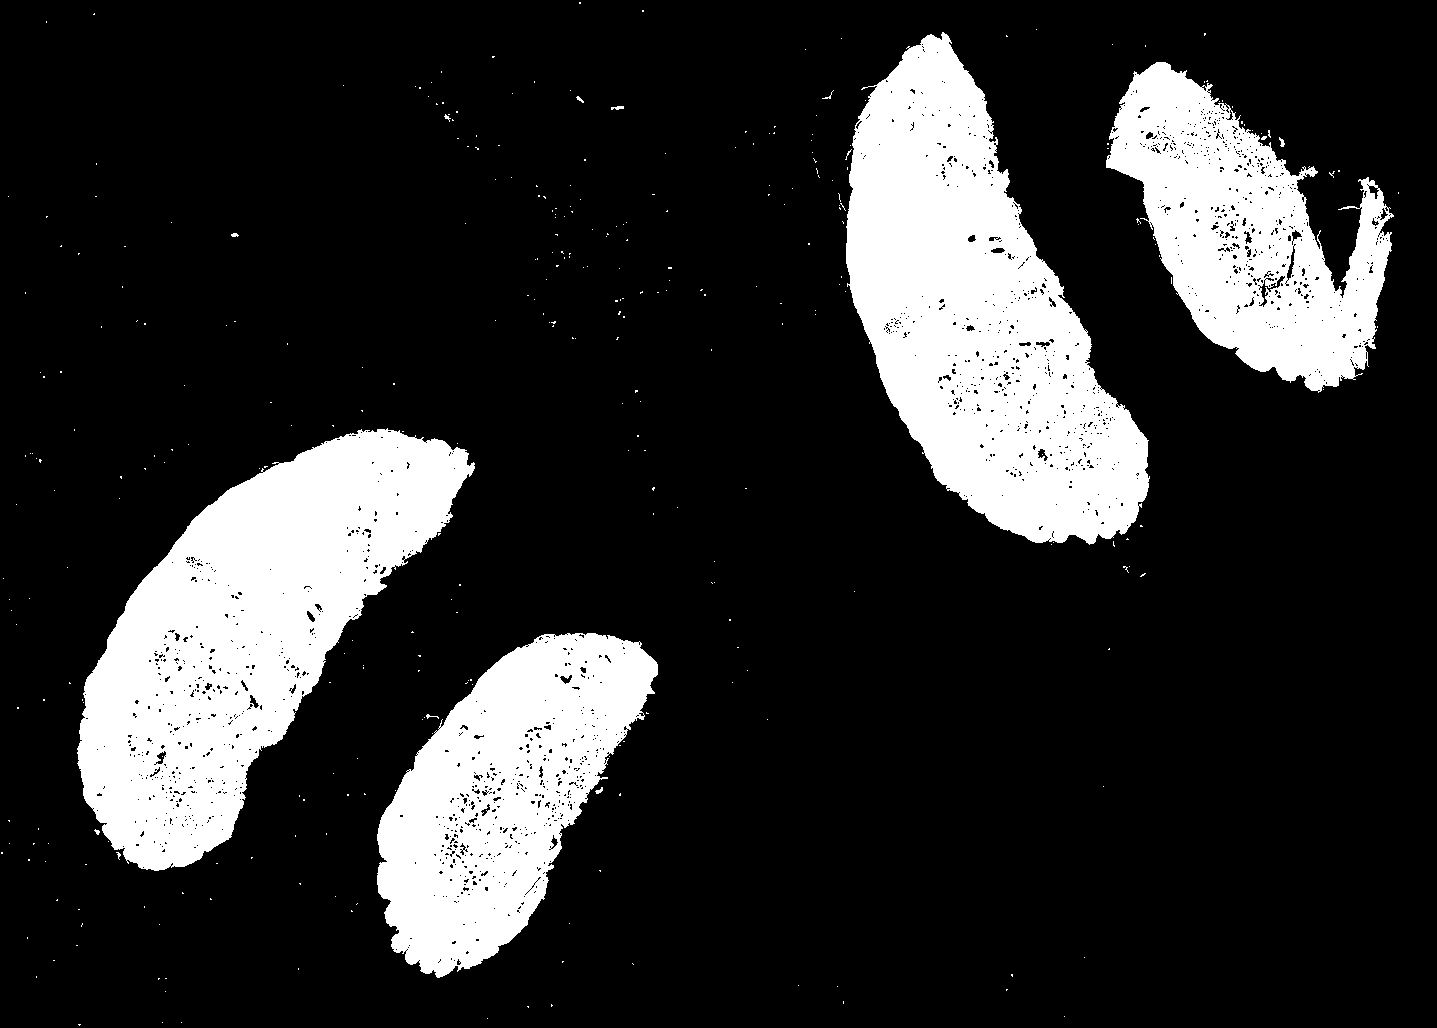

In [15]:
def test_fence_array_function():
    """ test_fence_array_function()
    """
    segment_length = 224
    length = segment_length*4 - 3

    print('\tget_adjcent_segmented_length_fence_array')
    print('\tn pixels: %i patch_length: %i\n'%(length, segment_length))
    fences_dict = get_adjcent_segmented_length_fence_array(segment_length, length)
    for k, v in fences_dict.items():
        if isinstance(v, np.ndarray):
            print('%20s:'%(k))
            for v_idx in range(v.shape[0]):
                if v[v_idx,1] - v[v_idx,0] != segment_length - 1:
                    print('%24s, %6i   Bug Bug'%(v[v_idx,0], v[v_idx,1]))
                else:
                    print('%24s, %6i'%(v[v_idx,0], v[v_idx,1]))
        else:
            print('%20s: %s'%(k,v))
            

def test_patch_names(out_test_dir):
    """ test_patch_names(out_test_dir)
    out_test_dir has jpg files named with the above naming functions
    """
    jpg_list = []
    for f in os.listdir(out_test_dir):
        _, f_ext = os.path.splitext(f)
        if f_ext == '.jpg':
            full_name = os.path.join(out_test_dir, f)
            if full_name in jpg_list:
                print('duplicate name: ???', full_name)
            else:
                jpg_list.append(full_name)

    n = 5
    for n in np.random.randint(0,999,5):
        _, one_name = os.path.split(jpg_list[n])
        print(one_name)
        rc_dict = get_row_col_from_patch_name(fname=jpg_list[n])

        bname = get_patch_name_from_row_col(rc_dict['row'],
                                            rc_dict['col'],
                                            rc_dict['base_name'],
                                            rc_dict['file_ext'])
        print(bname)
        print(rc_dict['row'], rc_dict['col'])
        print(rc_dict['base_name'], '\t\t', rc_dict['file_ext'], '\n')
        
print('test_fence_array_function')
test_fence_array_function()
out_test_dir = '../../DigiPath_MLTK_data/out_to_test'
print('\n\ntest_patch_names')
test_patch_names(out_test_dir)


#                                            run-test: get_mask_w_scale_grid
data_dir = '../../DigiPath_MLTK_data/Aperio'
files_list = ['CMU-1-Small-Region.svs', 'CMU-1.svs']

target_dir = '../../DigiPath_MLTK_data/out_to_test'
svs_file_name = os.path.join(data_dir, 'CMU-1.svs')

patch_height = 224
patch_width = 224

masked_dict = get_mask_w_scale_grid(svs_file_name, patch_height, patch_width)

big_r = masked_dict['full_scale_rows_arrays']
big_c = masked_dict['full_scale_cols_arrays']
sml_r = masked_dict['thumb_scale_rows_arrays']
sml_c = masked_dict['thumb_scale_cols_arrays']

thumb_mask = masked_dict['thumb_mask']
print('\nthumb_mask.size', thumb_mask.size)
print('\nrows:', big_r.shape, sml_r.shape, '\ncols:', big_c.shape, sml_c.shape, '\n')

n = 0
n_max = n+5
print('index\t[R,R] [C,C]\t[r,r] [c,c]')
for k in range(n, n_max):
    print(k, '\t', big_r[k,:], big_c[k,:], '\t', sml_r[k,:], sml_c[k,:])

n_rows = big_r.shape[0]
n_cols = big_c.shape[0]

for k in range(n_max, n, -1):
    kr = n_rows - k
    kc = n_cols - k
    print(kr, kc, '\t', big_r[kr,:], big_c[kc,:], '\t', sml_r[kr,:], sml_c[kc,:])

display(thumb_mask)